In [1]:
!pip install eli5

     |████████████████████████████████| 112kB 16.6MB/s 


In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.stats.stats import kendalltau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM, Masking
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import activations
sns.set()

In [3]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *

train_values = np.empty(shape=[0, 222])
test_values = np.empty(shape=[0, 222])

train_sampled_all = glob.glob('./drive/MyDrive/compsci/train_sampled_all_220.csv')
# test_sampled_all = glob.glob('./drive/MyDrive/compsci/test_sampled_all_centered_220.csv')
test_unsampled_all = glob.glob('./drive/MyDrive/compsci/test_unsampled_all_220.csv')

for j in train_sampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)
    
# for j in test_all:
#     print('Loading ', j)
#     csvrows = np.loadtxt(j, delimiter=',')
#     test_values = np.append(test_values, csvrows, axis=0)

for j in test_unsampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

Loading  ./drive/MyDrive/compsci/train_sampled_all_220.csv
Loading  ./drive/MyDrive/compsci/test_unsampled_all_220.csv
(31912, 222)
(37863, 222)


In [4]:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train_gc = (y_train - y_train.min())/(y_train.max()-y_train.min())*(9-1)
y_test_gc = (y_test - y_test.min())/(y_test.max()-y_test.min())*(9-1)

In [5]:
X_train1 = X_train.reshape(X_train.shape + (1,1))
X_test1 = X_test.reshape(X_test.shape + (1,1))

y_train1=to_categorical(y_train)
y_test1=to_categorical(y_test)

In [6]:
# class_num = 1

# N_train = train_values
# N_test = test_values[test_values[:,-2]==class_num]
# print(N_train.shape)
# print(N_test.shape)

# X_train = N_train[:,:-2]
# X_test = N_test[:,:-2]

# y_train = train_values[:len(N_train),-2]
# y_test = test_values[:len(N_test),-2]

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

# X_train1 = X_train.reshape(X_train.shape + (1,1,))
# X_test1 = X_test.reshape(X_test.shape + (1,1,))
# print(X_train1.shape)
# print(X_test1.shape)

# y_train1=to_categorical(y_train)
# y_test1=to_categorical(y_test)
# print(y_train1.shape)
# print(y_test1.shape)

In [7]:
def showResults(test, pred):
    #target_names = ['positive', 'negative']
    # print(classification_report(test, pred, target_names=target_names))
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    #loss=log_loss(test,pred)
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    #print("Loss : {}".format(loss))
    cm=confusion_matrix(test, pred)
    print(cm)
    return cm

In [8]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 5, 64
activationFunction='relu'

def getModel():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(X_train1.shape[1],1)))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=32, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(512, activation='relu'))
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 220, 128)          2176      
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 128)          512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 220, 32)           65568     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 220, 9)            4617      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 110, 9)            0         
_________________________________________________________________
flatten (Flatten)            (None, 990)               0

In [9]:
modelhistory= cnnmodel.fit(X_train1[:,:,:,0], y_train1, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Train on 25529 samples, validate on 6383 samples
Epoch 1/5
25529/25529 [==============================] - ETA: 0s - loss: 0.3254 - accuracy: 0.8918

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25529/25529 [==============================] - 10s 404us/sample - loss: 0.3254 - accuracy: 0.8918 - val_loss: 0.2599 - val_accuracy: 0.9315
Epoch 2/5
25529/25529 [==============================] - 3s 109us/sample - loss: 0.1228 - accuracy: 0.9593 - val_loss: 0.1233 - val_accuracy: 0.9593
Epoch 3/5
25529/25529 [==============================] - 3s 109us/sample - loss: 0.0834 - accuracy: 0.9726 - val_loss: 0.1132 - val_accuracy: 0.9665
Epoch 4/5
25529/25529 [==============================] - 3s 109us/sample - loss: 0.0680 - accuracy: 0.9778 - val_loss: 0.0953 - val_accuracy: 0.9720
Epoch 5/5
25529/25529 [==============================] - 3s 108us/sample - loss: 0.0575 - accuracy: 0.9799 - val_loss: 0.0930 - val_accuracy: 0.9738


<function matplotlib.pyplot.show>

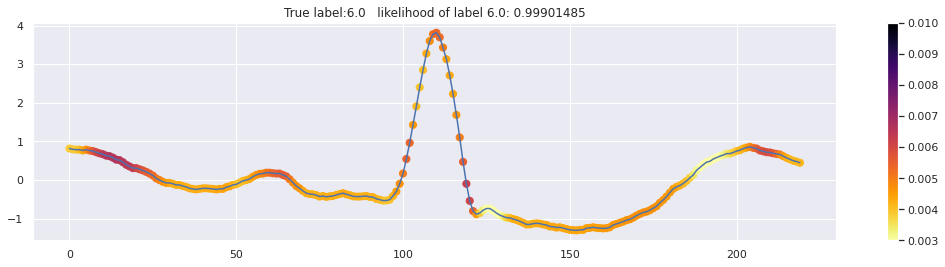

In [10]:
############## Get CAM ################
import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

get_last_conv1 = keras.backend.function([cnnmodel.layers[0].input, keras.backend.learning_phase()], [cnnmodel.layers[4].output])
last_conv1_cnn = get_last_conv1([X_test1[:1000,:,:,0]])[0]

get_softmax1_cnn = keras.backend.function([cnnmodel.layers[0].input, keras.backend.learning_phase()], [cnnmodel.layers[-1].output])
softmax1_cnn = get_softmax1_cnn(([X_test1[:1000,:,:,0]]))[0]
softmax_weight1_cnn = cnnmodel.get_weights()[-1]
softmax_weight_cnn = np.reshape(softmax_weight1_cnn,(9,1))

CAM = np.dot(last_conv1_cnn, softmax_weight_cnn)

# pp = PdfPages('CAM.pdf')
for k in range(1):
    CAM_cnn = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
    c = np.exp(CAM_cnn) / np.sum(np.exp(CAM_cnn), axis=1, keepdims=True)
    plt.figure(figsize=(18, 4))
    plt.plot(X_test1[k].squeeze())
    plt.scatter(np.arange(len(X_test1[k])), X_test1[k].squeeze(), cmap='inferno_r', c=c[k,:].squeeze(), s=50)
    # plt.title('True label:' + str(N_test[k,-2]) + '   likelihood of label ' + str(N_test[k,-2]) + ': ' + str(softmax1_cnn[k][int(y_test[k])]))
    plt.title('True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax1_cnn[k][int(y_test[k])]))
    plt.clim(0.003,0.010)
    plt.colorbar()
plt.show

In [11]:
cnnpredictions = cnnmodel.predict(X_test1[:,:,:,0], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy  : 0.9266038084673692
Precision : 0.9664741124118078
f1Score : 0.9401348747838951
[[26084    20    43   500  1714   264    54    24]
 [    1  1653     0     3     0     0     1     2]
 [    3     1  2471     6    16     1     2     0]
 [   10     5     2  1165     3    13     1     0]
 [   32     0     2     7   732     0     0     0]
 [    6     0     1     6     1   179     0     0]
 [    4     0     0     3     1     2   408    10]
 [    1     0     0     1     0     0    13  2392]]
              precision    recall  f1-score   support

           1      0.998     0.909     0.951     28703
           2      0.985     0.996     0.990      1660
           3      0.981     0.988     0.985      2500
           4      0.689     0.972     0.806      1199
           5      0.297     0.947     0.452       773
           6      0.390     0.927     0.549       193
           7      0.852     0.953     0.900       428
           8      0.985     0.994     0.989      2407

    accuracy

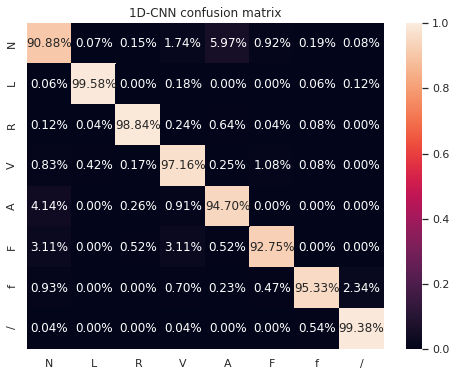

In [12]:
#performance metrics

cnn_predict=np.argmax(cnnpredictions,axis=1)
cnn_actual_value=np.argmax(y_test1,axis=1)
CNN_cf_m = showResults(cnn_actual_value, cnn_predict)
from sklearn import metrics
metrics = metrics.classification_report(cnn_actual_value, cnn_predict, digits=3)
print(metrics, 'CNN metrics')
categories=['N','L','R','V','A','F','f','/']
plt.figure(figsize=(8,6))
CNN_cf_m = CNN_cf_m.astype('float')/ CNN_cf_m.sum(axis=1)[:,np.newaxis]
sns.heatmap(CNN_cf_m,annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1)
plt.title('1D-CNN confusion matrix')
plt.show()

In [13]:
from itertools import islice
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return
a = last_conv1_cnn
new_last_conv1 = []

for i in range(len(last_conv1_cnn)):
  means = list(means_of_slices(a[i], 20))
  new_last_conv1.append(means)
new_last_conv1 = np.array(new_last_conv1)
print(new_last_conv1.shape)

final_last_conv1 = []
for i in new_last_conv1:
  final_last_conv1.append(np.repeat(i,20))
final_last_conv1 = np.array(final_last_conv1)
print(final_last_conv1.shape)

(1000, 11)
(1000, 220)


<function matplotlib.pyplot.show>

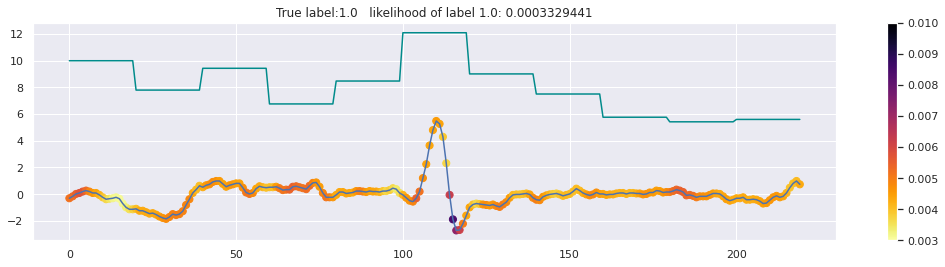

In [100]:
misclass_cnn = np.where(cnn_predict!=cnn_actual_value)

k=misclass_cnn[0][0]

CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
plt.figure(figsize=(18, 4))
plt.plot(X_test1[k].squeeze())
plt.scatter(np.arange(len(X_test1[k])), X_test1[k].squeeze(), cmap='inferno_r', c=c[k,:].squeeze(), s=50)
plt.plot(final_last_conv1[k], color = 'darkcyan')
# plt.title('True label:' + str(N_test[k,-2]) + '   likelihood of label ' + str(N_test[k,-2]) + ': ' + str(softmax1_cnn[k][int(y_test[k])]))
plt.title('True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax1_cnn[k][int(y_test[k])]))
plt.clim(0.003,0.010)
plt.colorbar()
plt.show

In [15]:
@#permutation feature weights

import eli5
from eli5 import format_as_image
from eli5.sklearn import PermutationImportance
from sklearn.neural_network import MLPClassifier
NNMLP_clf = MLPClassifier(random_state=48, max_iter=50)
NNMLP_clf.fit(new_last_conv1, y_test1[:1000])
perm = PermutationImportance(NNMLP_clf).fit(new_last_conv1, y_test1[:1000])
print('CNN results')
eli5.show_weights(perm)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


CNN results


Weight,Feature
0.1060 ± 0.0069,x7
0.0452 ± 0.0127,x6
0.0382 ± 0.0071,x8
0.0350 ± 0.0138,x2
0.0240 ± 0.0095,x4
0.0220 ± 0.0123,x5
0.0180 ± 0.0031,x3
0.0086 ± 0.0060,x9
0.0078 ± 0.0070,x10
0.0072 ± 0.0034,x1


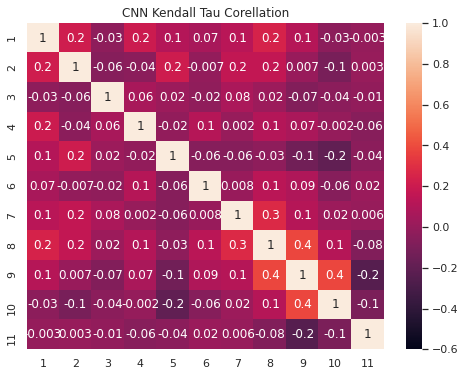

In [16]:
#Kendall tau correlation

conv_df_slices = pd.DataFrame(new_last_conv1)
corr_slices = conv_df_slices.corr(method='kendall')
slices_nums = [1,2,3,4,5,6,7,8,9,10,11]
rcParams['figure.figsize'] = 8,6
sns.heatmap(corr_slices,annot=True,xticklabels=slices_nums,yticklabels=slices_nums,vmin=-0.6,vmax=1,fmt='0.1g')
plt.title('CNN Kendall Tau Corellation')
plt.show()

<function matplotlib.pyplot.show>

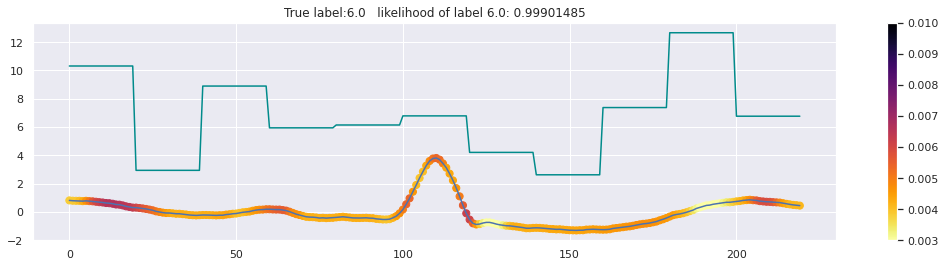

In [17]:
############## Get CAM ################
import matplotlib.pyplot as plt

CAM = np.dot(last_conv1_cnn, softmax_weight_cnn)

# pp = PdfPages('CAM.pdf')
for k in range(1):
    CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
    c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
    plt.figure(figsize=(18, 4))
    plt.plot(X_test1[k].squeeze())
    plt.scatter(np.arange(len(X_test1[k])), X_test1[k].squeeze(), cmap='inferno_r', c=c[k,:].squeeze(), s=50)
    plt.plot(final_last_conv1[k], color = 'darkcyan')
    # plt.title('True label:' + str(N_test[k,-2]) + '   likelihood of label ' + str(N_test[k,-2]) + ': ' + str(softmax1_cnn[k][int(y_test[k])]))
    plt.title('True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax1_cnn[k][int(y_test[k])]))
    plt.clim(0.003,0.010)
    plt.colorbar()
plt.show

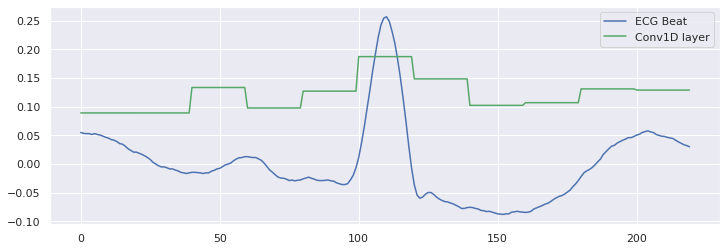

In [18]:
from sklearn.preprocessing import normalize

n1= normalize(final_last_conv1)
n2= normalize(X_test)

m1=n1.mean(axis=0)

plt.figure(figsize=(12,4))
plt.plot(n2[0],color='b',label='ECG Beat')
plt.plot(m1*2,color='g',label='Conv1D layer')
# plt.title('Class: /, Number: ' + str(class_num))
plt.legend()
plt.show()

In [19]:
# # saving the model

# model_json = cnnmodel.to_json()
# with open("NEWcnnmodel_testunsam.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# cnnmodel.save_weights("NEWcnnmodel_testunsam_weights.h5")
# cnnmodel.save("NEWcnnmodel_testunsam.h5")
# print("Saved model to disk")